# ISBI 2024 DiMEDIA: MONAI Tutorial: DDIM + Classifier Free Guidance

This tutorial illustrates how to use MONAI for training a denoising diffusion implicit model (DDIM) to create synthetic 2D images using the classifier-free guidance technique [1] to perform conditioning.


In [1]:
import os
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler, DDIMScheduler

print_config()
set_determinism(42)


MONAI version: 1.3.0
Numpy version: 1.26.2
Pytorch version: 2.2.2+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /remote/rds/users/<username>/miniforge3/envs/dev/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 5.2.1
scikit-image version: 0.22.0
scipy version: 1.11.4
Pillow version: 10.3.0
Tensorboard version: 2.16.2
gdown version: 4.7.3
TorchVision version: 0.17.2+cu118
tqdm version: 4.66.1
lmdb version: 1.4.1
psutil version: 5.9.5
pandas version: 2.1.4
einops version: 0.7.0
transformers version: 4.39.3
mlflow version: 2.11.3
pynrrd version: 1.0.0
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup MedNIST Dataset

In this tutorial, we will train our models on the MedNIST dataset available on MONAI `https://docs.monai.io/en/stable/apps.html#monai.apps.MedNISTDataset`. 

Here, we will use the `Hand` and `HeadCT`, where our conditioning variable `class` will specify the modality.

In [2]:
root_dir = './'
data_dir = './data/'
os.makedirs(data_dir, exist_ok=True)
train_data = MedNISTDataset(root_dir=data_dir, section="training", download=True, progress=False, seed=0)
train_datalist = []
for item in train_data.data:
    if item["class_name"] in ["Hand", "HeadCT"]:
        train_datalist.append({"image": item["image"], "class": 1 if item["class_name"] == "Hand" else 2})

train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.RandAffined(
            keys=["image"],
            rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
            translate_range=[(-1, 1), (-1, 1)],
            scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
            spatial_size=[64, 64],
            padding_mode="zeros",
            prob=0.5,
        ),
        transforms.RandLambdad(keys=["class"], prob=0.15, func=lambda x: -1 * torch.ones_like(x)),
        transforms.Lambdad(
            keys=["class"], func=lambda x: torch.tensor(x, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        ),
    ]
)
train_ds = CacheDataset(data=train_datalist, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=4, persistent_workers=True)

val_data = MedNISTDataset(root_dir=data_dir, section="validation", download=True, progress=False, seed=0)
val_datalist = []
for item in val_data.data:
    if item["class_name"] in ["Hand", "HeadCT"]:
        val_datalist.append({"image": item["image"], "class": 1 if item["class_name"] == "Hand" else 2})


val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.Lambdad(
            keys=["class"], func=lambda x: torch.tensor(x, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        ),
    ]
)
val_ds = CacheDataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=4, persistent_workers=True)

2024-05-24 10:58:52,027 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-05-24 10:58:52,029 - INFO - File exists: data/MedNIST.tar.gz, skipped downloading.
2024-05-24 10:58:52,031 - INFO - Non-empty folder exists in data/MedNIST, skipped extracting.


Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████| 15990/15990 [00:29<00:00, 533.13it/s]


2024-05-24 11:01:01,852 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-05-24 11:01:01,854 - INFO - File exists: data/MedNIST.tar.gz, skipped downloading.
2024-05-24 11:01:01,857 - INFO - Non-empty folder exists in data/MedNIST, skipped extracting.


Loading dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1977/1977 [00:03<00:00, 556.34it/s]


### Visualisation of the training images


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


batch shape: torch.Size([128, 1, 64, 64])


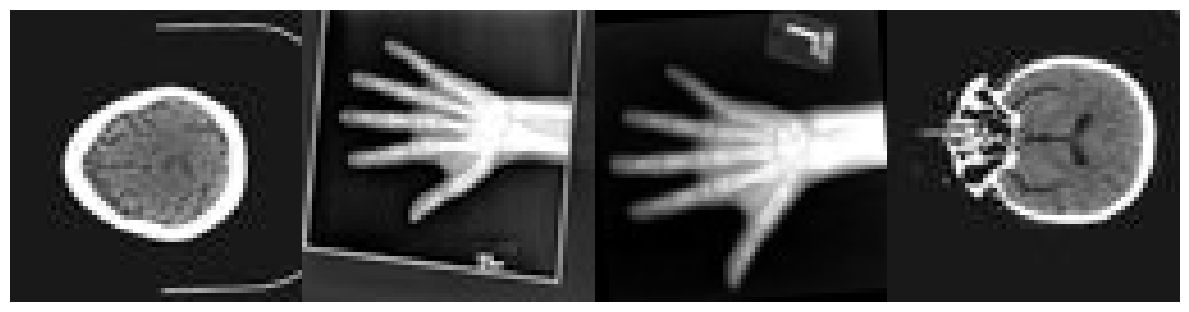

In [3]:
check_data = first(train_loader)
print(f"batch shape: {check_data['image'].shape}")
image_visualisation = torch.cat(
    [check_data["image"][0, 0], check_data["image"][1, 0], check_data["image"][2, 0], check_data["image"][3, 0]], dim=1
)
plt.figure("training images", (12, 6))
plt.imshow(image_visualisation, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

## Define network, scheduler, optimizer, and inferer

We are using the original DDPM scheduler containing `1000` timesteps in its Markov chain, and a 2D UNET with attention mechanisms in the 3rd level, each with 1 attention head (`num_head_channels=64`).

In order to pass conditioning variables with dimension of 1 (just specifying the modality of the image), we use `with_conditioning=True, cross_attention_dim=1`.

We will also use `DDIMScheduler` to enable faster sampling.

In [4]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(64, 64, 64),
    attention_levels=(False, False, True),
    num_res_blocks=1,
    num_head_channels=(0, 0, 64),
    with_conditioning=True,
    cross_attention_dim=1,
)
model.to(device)

scheduler = DDPMScheduler(num_train_timesteps=1000)

optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)

inferer = DiffusionInferer(scheduler)

## Model training

Here, we are training our model for 75 epochs (training time: ~50 minutes).

For the purpose of tutorial, we would like to skip the training and use a pre-trained model instead, set `use_pretrained=True`.

In [5]:
use_pretrained = True

if use_pretrained:
    model = DiffusionModelUNet(
        spatial_dims=2,
        in_channels=1,
        out_channels=1,
        num_channels=(64, 64, 64),
        attention_levels=(False, False, True),
        num_res_blocks=1,
        num_head_channels=(0, 0, 64),
        with_conditioning=True,
        cross_attention_dim=1,
    )
    os.makedirs('./pretrained/', exist_ok=True)
    import urllib.request
    url = 'https://raw.githubusercontent.com/vios-s/ISBI-2024-DiMEDIA-MONAI-Tutorial/main/pretrained/classifier_free.pt'
    print ("Download start!")
    filename, headers = urllib.request.urlretrieve(url, filename="./pretrained/classifier_free.pt")
    print("Download Complete.")
    model.load_state_dict(torch.load('./pretrained/classifier_free.pt'))
    model.to(device)
else:
    n_epochs = 75
    val_interval = 5
    epoch_loss_list = []
    val_epoch_loss_list = []
    
    scaler = GradScaler()
    total_start = time.time()
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
        progress_bar.set_description(f"Epoch {epoch}")
        for step, batch in progress_bar:
            images = batch["image"].to(device)
            classes = batch["class"].to(device)
            optimizer.zero_grad(set_to_none=True)
    
            with autocast(enabled=True):
                # Generate random noise
                noise = torch.randn_like(images).to(device)
                # Create timesteps
                timesteps = torch.randint(
                    0, 
                    inferer.scheduler.num_train_timesteps, 
                    (images.shape[0],), 
                    device=images.device
                ).long()
                # Get model prediction
                noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, condition=classes, timesteps=timesteps)
    
                loss = F.mse_loss(noise_pred.float(), noise.float())
    
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
    
            epoch_loss += loss.item()
    
            progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
        epoch_loss_list.append(epoch_loss / (step + 1))
    
        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_epoch_loss = 0
            for step, batch in enumerate(val_loader):
                images = batch["image"].to(device)
                classes = batch["class"].to(device)
                timesteps = torch.randint(
                            0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                        ).long()
                with torch.no_grad():
                    with autocast(enabled=True):
                        noise = torch.randn_like(images).to(device)
                        noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, condition=classes, timesteps=timesteps)
                        val_loss = F.mse_loss(noise_pred.float(), noise.float())
    
                val_epoch_loss += val_loss.item()
                progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})
            val_epoch_loss_list.append(val_epoch_loss / (step + 1))

            # Sampling image during training
            noise = torch.randn((1, 1, 64, 64))
            noise = noise.to(device)
            condition = (2 * torch.ones((1, 1, 1))).to(device)
            scheduler.set_timesteps(num_inference_steps=1000)
            with autocast(enabled=True):
                image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler, conditioning=condition)

            plt.figure(figsize=(2, 2))
            plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
            plt.tight_layout()
            plt.axis("off")
            plt.show()
    
    total_time = time.time() - total_start
    print(f"train completed, total time: {total_time}.")
    torch.save(model.state_dict(), 'pretrained/classifier_free.pt')

Download start!
Download Complete.


## Sampling process with classifier-free guidance

In order to sample using classifier-free guidance, for each step of the process we need to have 2 elements, one generated conditioned in the desired class (here we want to condition on Hands `=1`) and one using the unconditional class (`=-1`). 

Instead using directly the predicted class in every step, we use the unconditional plus the direction vector pointing to the condition that we want (`noise_pred_text - noise_pred_uncond`). The effect of the condition is defined by the `guidance_scale` defining the influence of our direction vector.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 47.09it/s]


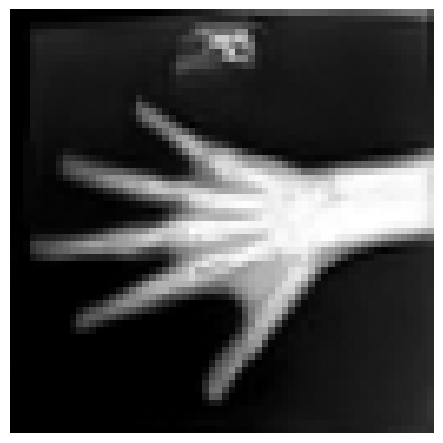

In [6]:
model.eval()
guidance_scale = 7.0
conditioning = torch.cat([-1 * torch.ones(1, 1, 1).float(), torch.ones(1, 1, 1).float()], dim=0).to(device)

noise = torch.randn((1, 1, 64, 64))
noise = noise.to(device)
scheduler.set_timesteps(num_inference_steps=1000)
progress_bar = tqdm(scheduler.timesteps)
for t in progress_bar:
    with autocast(enabled=True):
        with torch.no_grad():
            noise_input = torch.cat([noise] * 2)
            model_output = model(noise_input, timesteps=torch.Tensor((t,)).to(noise.device), context=conditioning)
            noise_pred_uncond, noise_pred_text = model_output.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    noise, _ = scheduler.step(noise_pred, t, noise)

plt.style.use("default")
plt.imshow(noise[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:05<00:00, 47.99it/s]


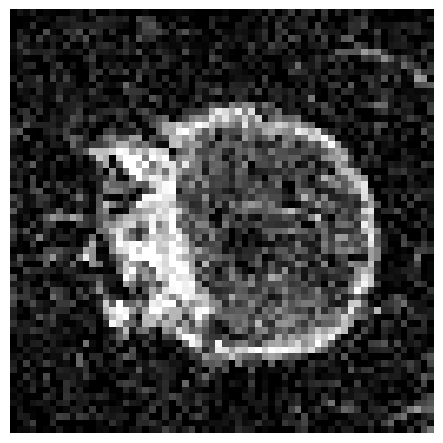

In [7]:
model.eval()
guidance_scale = 7.0
conditioning = torch.cat([-1 * torch.ones(1, 1, 1).float(), 2*torch.ones(1, 1, 1).float()], dim=0).to(device)

noise = torch.randn((1, 1, 64, 64))
noise = noise.to(device)

scheduler_ddim = DDIMScheduler(
    num_train_timesteps=1000, schedule="scaled_linear_beta", beta_start=0.0005, beta_end=0.0195, clip_sample=False
)
scheduler_ddim.set_timesteps(num_inference_steps=250)
progress_bar = tqdm(scheduler_ddim.timesteps)
for t in progress_bar:
    with autocast(enabled=True):
        with torch.no_grad():
            noise_input = torch.cat([noise] * 2)
            model_output = model(noise_input, timesteps=torch.Tensor((t,)).to(noise.device), context=conditioning)
            noise_pred_uncond, noise_pred_text = model_output.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    noise, _ = scheduler_ddim.step(noise_pred, t, noise)

plt.style.use("default")
plt.imshow(noise[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()